This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

In [6]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Getting started with neural networks: classification and regression

## Classifying movie reviews: a binary classification example

Two-class classification, or binary classification, is one of the most common kinds of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.

### The IMDB dataset

You’ll work with the IMDB dataset: a set of $50,000$ highly polarized reviews from the Internet Movie Database. They’re split into $25,000$ reviews for training and $25,000$ reviews for testing, each set consisting of $50\%$ negative and $50\%$ positive reviews.

**Loading the IMDB dataset**

The argument `num_words=10000` means you’ll only keep the top $10,000$ most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size. If we didn’t set this limit, we’d be working with $88,585$ unique words in the training data, which is unnecessarily large. Many of these words only occur in a single sample, and thus can’t be meaningfully used for classification.

In [7]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000, index_from=3)

In [8]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [9]:
train_labels[0]

1

Because you’re restricting yourself to the top $10,000$ most frequent words, no word index will exceed 10,000:

In [10]:
max([max(sequence) for sequence in train_data])

9999

**Decoding reviews back to text**

In [11]:
# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index.get(i - 3, "?") for i in train_data[0])

1654784/1641221 [==============================] - 1s 0us/step


In [12]:
decoded_sequence

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Preparing the data

You can’t directly feed lists of integers into a neural network. They have all different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two ways to do that:

- **Pad** your lists so that they all have the same length, then turn them into an integer tensor of shape (samples, max_length), and start your model with a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book).
- **Multi-hot encode** your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a Dense layer, capable of handling floating-point vector data, as the first layer in your model.

In [53]:
[len(sentence) for sentence in train_data]

[218,
 189,
 141,
 550,
 147,
 43,
 123,
 562,
 233,
 130,
 450,
 99,
 117,
 238,
 109,
 129,
 163,
 752,
 212,
 177,
 129,
 140,
 256,
 888,
 93,
 142,
 220,
 193,
 171,
 221,
 174,
 647,
 233,
 162,
 597,
 234,
 51,
 336,
 139,
 231,
 704,
 142,
 861,
 132,
 122,
 570,
 55,
 214,
 103,
 186,
 113,
 169,
 469,
 138,
 302,
 766,
 351,
 146,
 59,
 206,
 107,
 152,
 186,
 431,
 147,
 684,
 383,
 324,
 252,
 263,
 787,
 211,
 314,
 118,
 390,
 132,
 710,
 306,
 167,
 115,
 95,
 158,
 156,
 82,
 502,
 314,
 190,
 174,
 60,
 145,
 214,
 659,
 408,
 515,
 461,
 202,
 238,
 170,
 107,
 171,
 158,
 145,
 790,
 258,
 287,
 67,
 123,
 975,
 775,
 236,
 195,
 274,
 214,
 91,
 1038,
 815,
 183,
 206,
 50,
 118,
 147,
 141,
 60,
 56,
 439,
 439,
 213,
 144,
 533,
 303,
 203,
 563,
 129,
 153,
 55,
 92,
 174,
 187,
 183,
 165,
 78,
 198,
 156,
 223,
 127,
 61,
 362,
 84,
 57,
 176,
 159,
 57,
 159,
 165,
 213,
 194,
 149,
 130,
 203,
 19,
 98,
 466,
 525,
 130,
 322,
 153,
 408,
 215,
 472,
 143,
 1

**Encoding the integer sequences via multi-hot encoding**

In [23]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # ith row, and all columns that are actual in the sentence
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [65]:
x_train.shape

(25000, 10000)

In [58]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a plain stack of densely-connected (Dense) layers with relu activations.

There are two key architecture decisions to be made about such a stack of Dense layers:

- How many layers to use
- How many units to choose for each layer

**Model definition**

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/3_layer_network.png)

The intermediate layers use `relu` as their activation function, and the final layer uses a `sigmoid` activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1": how likely the review is to be positive). A `relu` (rectified linear unit) is a function meant to **zero out negative values**, whereas a sigmoid "squashes" arbitrary values into the $[0, 1]$ interval (see figure 4.3), outputting something that can be interpreted as a **probability**.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/The-rectified-linear-unit-function.png)

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/The-sigmoid-function.png)

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**Compiling the model**

In [60]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [67]:
shuffled_index = np.random.permutation(range(x_train.shape[0]))

x_val = x_train[shuffled_index][:10000]
partial_x_train = x_train[shuffled_index][10000:]
y_val = y_train[shuffled_index][:10000]
partial_y_train = y_train[shuffled_index][10000:]

**Training your model**

In [68]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.5327 - accuracy: 0.7833 - val_loss: 0.4029 - val_accuracy: 0.8642
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3181 - accuracy: 0.8995 - val_loss: 0.3190 - val_accuracy: 0.8828
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2284 - accuracy: 0.9295 - val_loss: 0.2903 - val_accuracy: 0.8865
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1788 - accuracy: 0.9430 - val_loss: 0.2890 - val_accuracy: 0.8865
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1421 - accuracy: 0.9575 - val_loss: 0.2981 - val_accuracy: 0.8830
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1176 - accuracy: 0.9651 - val_loss: 0.3283 - val_accuracy: 0.8784
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0961 - accuracy: 0.9727 - val_loss: 0.3480 - val_accuracy: 0.8762
Epoch 8/20
30/30 

In [69]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the training and validation loss**

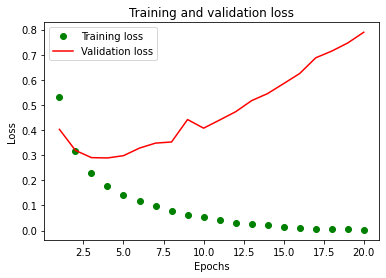

In [73]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "og", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

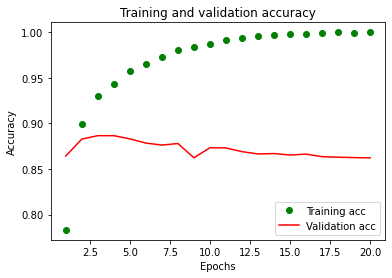

In [74]:
plt.clf()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "go", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient-descent optimization—the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is **overfitting**: after the fourth epoch, you’re over-optimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

**Retraining a model from scratch**

In [76]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test, return_dict=True)

Epoch 1/4
49/49 [==============================] - 1s 6ms/step - loss: 0.4915 - accuracy: 0.8150
Epoch 2/4
49/49 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.90 - 0s 6ms/step - loss: 0.2823 - accuracy: 0.9049
Epoch 3/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2116 - accuracy: 0.9264
Epoch 4/4
782/782 [==============================] - 25s 31ms/step - loss: 0.2926 - accuracy: 0.8843


In [77]:
results

{'loss': 0.29259607195854187, 'accuracy': 0.8842800259590149}

### Using a trained model to generate predictions on new data

In [78]:
model.predict(x_test)

array([[0.16073775],
       [0.99819577],
       [0.8550322 ],
       ...,
       [0.09465057],
       [0.06173232],
       [0.5093109 ]], dtype=float32)

### Further experiments

The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:

- You used two representation layers before the final classification layer. Try using one or three representation layers, and see how doing so affects validation and test accuracy.
- Try using layers with more units or fewer units: $32$ units, $64$ units, and so on.
- Try using the `mse` loss function instead of `binary_crossentropy`.
- Try using the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

### Wrapping up

- You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
- Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
- In a binary classification problem (two output classes), your model should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your model should be a scalar between $0$ and $1$, encoding a probability.
- With such a scalar `sigmoid` output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
- The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
- As they get better on their training data, neural networks eventually start **overfitting** and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.